# 3. Data Modeling

## Implement Baselines
<hr>

To fit our baseline model we will use OLS (Ordinary Least Squares Regression). We will split our dataset into a train and test (65 / 35) and run 10 Linear Regression simulations to calculate the Train and Test Score. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pylab
import scipy.stats as stats
import math
%matplotlib inline

In [2]:
# helper function for plotting residual plots
def plot_residual(ax1, ax2, ax3, y_pred, y_real, line_label, title):
    ax1.scatter(y_pred, 
                y_real, 
                color='blue',
                alpha=0.6,
                label=line_label)
    ax1.set_xlabel('Predicted Y') 
    ax1.set_ylabel('Real Y')
    ax1.legend(loc='best')
    ax1.set_title(title)

    ax2.scatter(y_pred,
                y_real - y_pred, 
                color='green',
                marker='x',
                alpha=0.6,
                label='Residual')
    ax2.set_xlabel('Predicted Y')
    ax2.set_ylabel('Residual')
    
    ax2.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')

    ax2.legend(loc='best')
    ax2.set_title('Residual Plot')
    
    ax3.hist(y_real - y_pred, bins=30, color='green', alpha=0.7)
    ax3.set_title('Histogram of residual values')
    
    return ax1, ax2, ax3

In [3]:
class model:
    
    def __init__(self, model):
        self.model = model
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.y_pred_train = None
        self.y_pred_test = None
        self.train_score = None
        self.test_score = None
        self.train_score_log = None
        self.test_score_log = None
    
    def data_split(self, x, y, test_size):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=test_size)
    
    def score_reg(self):
        return self.train_score, self.test_score
    
    def score_log(self):
        self.train_score_log = metrics.r2_score(np.exp(self.y_train), np.exp(self.y_pred_train))
        self.test_score_log = metrics.r2_score(np.exp(self.y_test), np.exp(self.y_pred_test))
        return self.train_score_log, self.test_score_log
    
    def data_frame_convert(self):
        df_train = pd.DataFrame({'y_pred': self.y_pred_train, 'y_real': self.y_train})
        df_test = pd.DataFrame({'y_pred_test': self.y_pred_test, 'y_real_test': self.y_test})
        return self.train_score, self.test_score, df_train, df_test

    def data_frame_convert_log(self):
        df_train = pd.DataFrame({'y_pred': np.exp(self.y_pred_train), 'y_real': np.exp(self.y_train)})
        df_test = pd.DataFrame({'y_pred_test': np.exp(self.y_pred_test), 'y_real_test': np.exp(self.y_test)})
        return self.train_score_log, self.test_score_log, df_train, df_test
    
    def fit_model(self, x, y, test_size):
        self.data_split(x, y, test_size)
        self.model = self.model.fit(self.x_train, self.y_train)
        self.train_score = self.model.score(self.x_train, self.y_train)
        self.test_score = self.model.score(self.x_test, self.y_test)
        self.y_pred_train = self.model.predict(self.x_train)
        self.y_pred_test = self.model.predict(self.x_test)
    
def model_iterations(n, x, y, model_arg, log_bool=False):
    new_model = model(model_arg)
    training_scores = [None]*n
    testing_scores = [None]*n

    for i in range(n):
        new_model.fit_model(x, y, 0.3)
        training_scores[i], testing_scores[i] = new_model.score_reg() if not log_bool else new_model.score_log()

    print 'Mean Train Score:', np.mean(training_scores)
    print 'Mean Test Score:', np.mean(testing_scores)
    return new_model

In [4]:
data = pd.read_csv('../datasets/listings_neighborhood_clean.csv')
data.head()

,id,host_id,accommodates,bathrooms,bedrooms,beds,minimum_nights,availability_30,number_of_reviews,host_listing_count,...,50-59,60-69,70-79,80-84,85-89,90-94,95-100,No Reviews,price,price_log
0,1069266,5867023,-0.520256,-0.331519,-0.407440,-0.493059,0.173446,0.390321,2.716276,-0.355986,...,0,0,0,0,1,0,0,0,160.0,5.075174
1,2061725,4601412,-0.520256,-0.331519,-0.407440,0.381668,0.173446,-0.965980,1.295702,0.932775,...,0,0,0,0,0,0,1,0,58.0,4.060443
2,44974,198425,-0.520256,-0.331519,-0.407440,-0.493059,2.885991,-1.205327,0.822177,-0.355986,...,0,0,0,0,0,0,1,0,185.0,5.220356
3,4701675,22590025,-0.520256,-0.331519,-0.407440,0.381668,-0.601567,1.108363,-0.493170,-0.355986,...,0,0,0,0,0,0,1,0,195.0,5.273000
4,68914,343302,1.690843,-0.331519,1.266082,1.256396,-0.214061,-0.407503,0.296038,0.073601,...,0,0,0,0,0,0,1,0,165.0,5.105945


In [5]:
# split into x and y (note that we do not include id and host_id as predictors)
x = data.iloc[:, 2:-2]
y = data.iloc[:, -2]
y_log = data.iloc[:, -1]

## Linear Regression Model

### Linear Regression with Non Log-Transformed Response

In [9]:
Lin_Reg_Model = model_iterations(1, x, y, Lin_Reg(fit_intercept=True))

Mean Train Score: 0.318319108753
Mean Test Score: -4.25950339536e+17


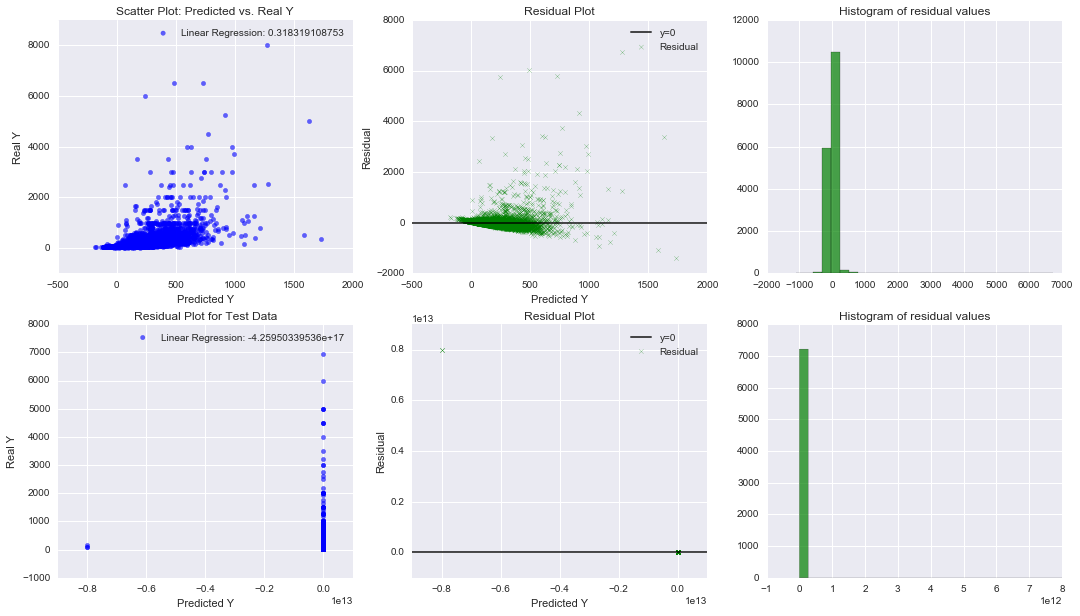

In [10]:
# plot the residuals of a linear regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_vals = Lin_Reg_Model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], data_vals[2]['y_pred'], data_vals[2]['y_real'], 'Linear Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], data_vals[3]['y_pred_test'], data_vals[3]['y_real_test'], 'Linear Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()

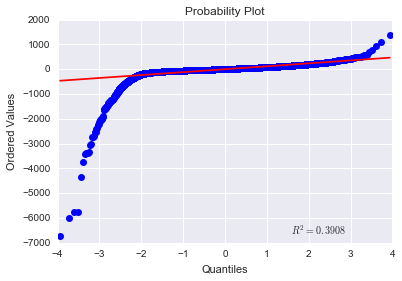

In [11]:
# qq plot for the train residuals
stats.probplot(data_vals[2]['y_pred'] - data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Linear Regression with Log-Transformed Response

In [12]:
Lin_Reg_Model = model_iterations(1, x, y_log, Lin_Reg(fit_intercept=True), True)

Mean Train Score: 0.370143716483
Mean Test Score: 0.248905976598


NameError: name 'Lin_Reg_Model_Log' is not defined

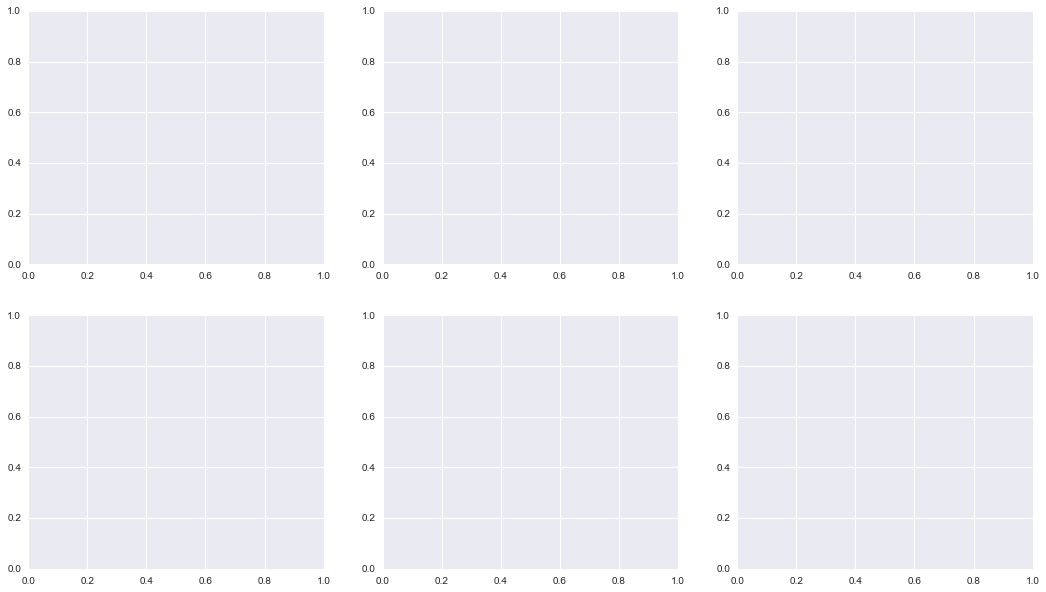

In [13]:
# plot the residuals of a linear regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

data_vals = Lin_Reg_Model_Log.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], data_vals[2]['y_pred'], data_vals[2]['y_real'], 'Linear Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], data_vals[3]['y_pred_test'], data_vals[3]['y_real_test'], 'Linear Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()

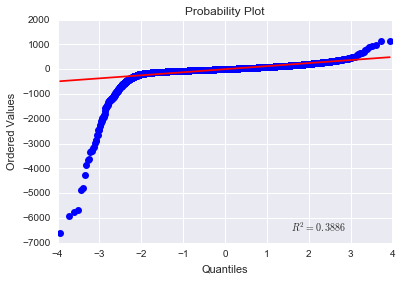

In [27]:
# qq plot for the train residuals
stats.probplot(data_vals[2]['y_pred'] - data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Linear Regression Analysis

We see that while we are achieving a low $R^2$ score on the train set, we are achieving an extremely negative $R^2$ score on the test set. Based on the residual plots for the train, we can see that a linear regression does not perform well as it predicts a negative price when the actual price is close to 0. From the residual plot itself, we see a strong outwards shaping pattern in the residuals which indicates non-linearity in the data. Plotting a Q-Q plot of the train residuals, we see that the residuals are indeed not normally distributed. Plotting the residuals in the test, we can see that a majority of the values were predicted to be 0 while there were many cases where the real y-value was not 0. There were also cases were the actual price was as high as 8000 when a linear regression model predicted 0. Such discrepency in the predictions from the actual values explains why such a low negative $R^2$ was obtained.

### Linear Regression with Log-Transformed Response

We see that linear regression with a log-transformed response yields a similar $R^2$ value for the train set, though a significantly higher $R^2$ value for the test set. The train scores remain similar for both the transformed and non-transformed linear regression model. It is important to note, however, that for the log-transformed linear regression model, the distribution of the residual plot more closely resembles that of a normal distribution (Q-Q $R^2$ value of 0.9357 vs. 0.3757).

We next fit a RidgeCV regression.

## Ridge & Lasso Regression

### Ridge Regression with Non Log-Transformed Response

In [6]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(1, x, y, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5))

Mean Train Score: 0.317389383417
Mean Test Score: 0.287039215886


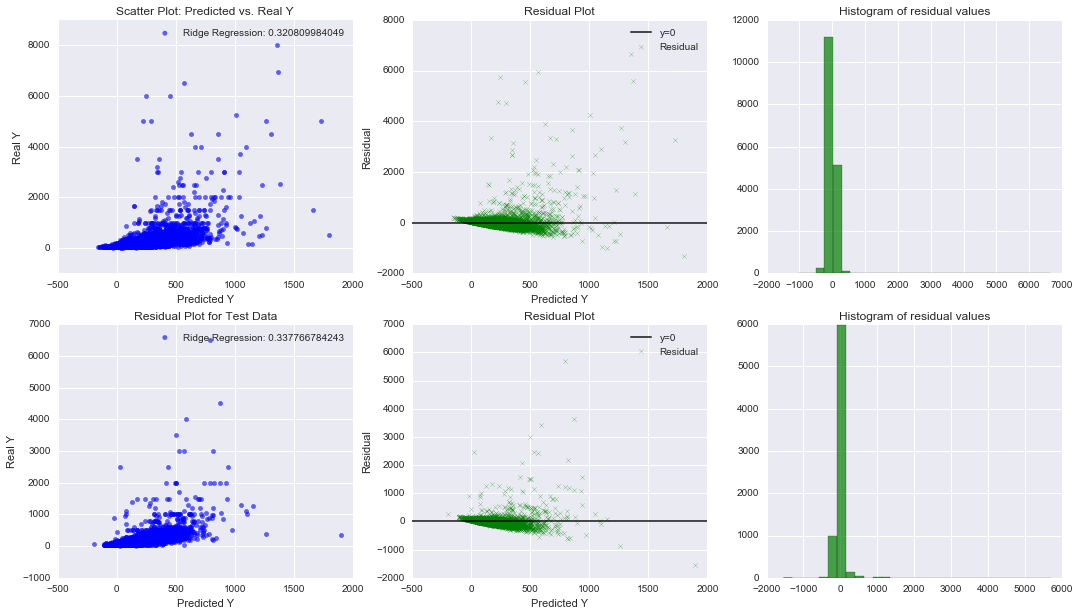

In [29]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

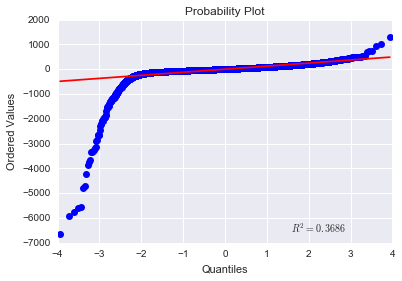

In [30]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Ridge Regression with Log-Transformed Response

In [31]:
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(5, x, y_log, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5), True)

Mean Train Score: 0.355490988957
Mean Test Score: 0.361796683246


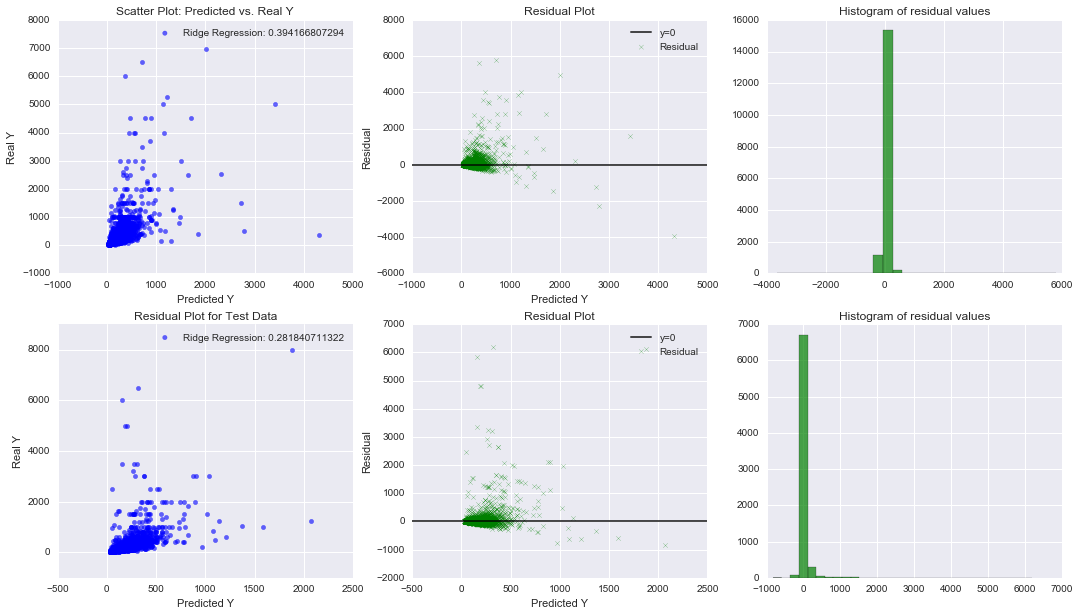

In [32]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

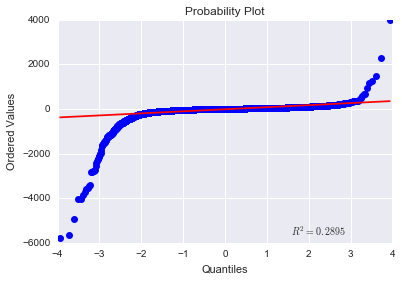

In [33]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Lasso Regression with Non-Transformed Response

In [34]:
reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x, y, LassoCV(alphas=reg_params, fit_intercept=True, cv=5))

/Users/AlexPeed/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Mean Train Score: 0.332268851922
Mean Test Score: 0.310043979761


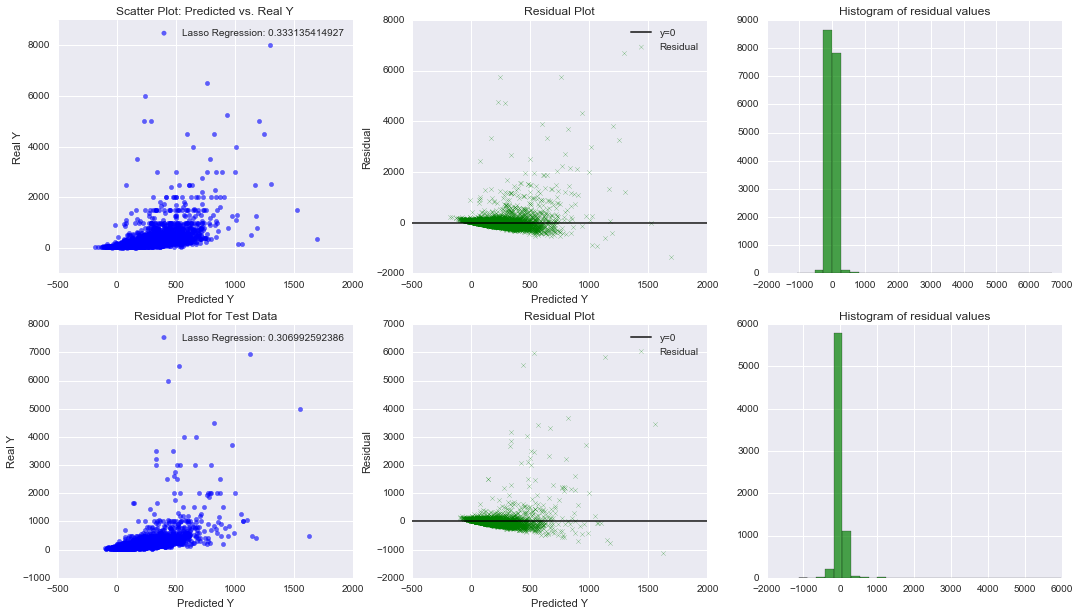

In [35]:
# plot the residuals for a lasso regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

lasso_data_vals = LassoCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], lasso_data_vals[2]['y_pred'], lasso_data_vals[2]['y_real'], 'Lasso Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], lasso_data_vals[3]['y_pred_test'], lasso_data_vals[3]['y_real_test'], 'Lasso Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()

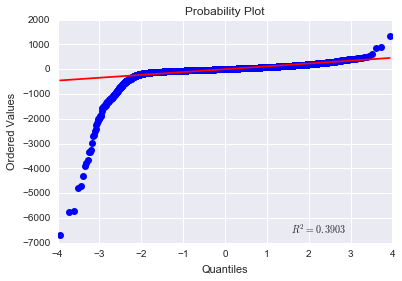

In [36]:
# qq plot for the train residuals
stats.probplot(lasso_data_vals[2]['y_pred'] - lasso_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Lasso Regression with Log-Transformed Response

In [37]:
reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x, y_log, LassoCV(alphas=reg_params, fit_intercept=True, cv=5), True)

Mean Train Score: 0.362542038651
Mean Test Score: 0.340433970597


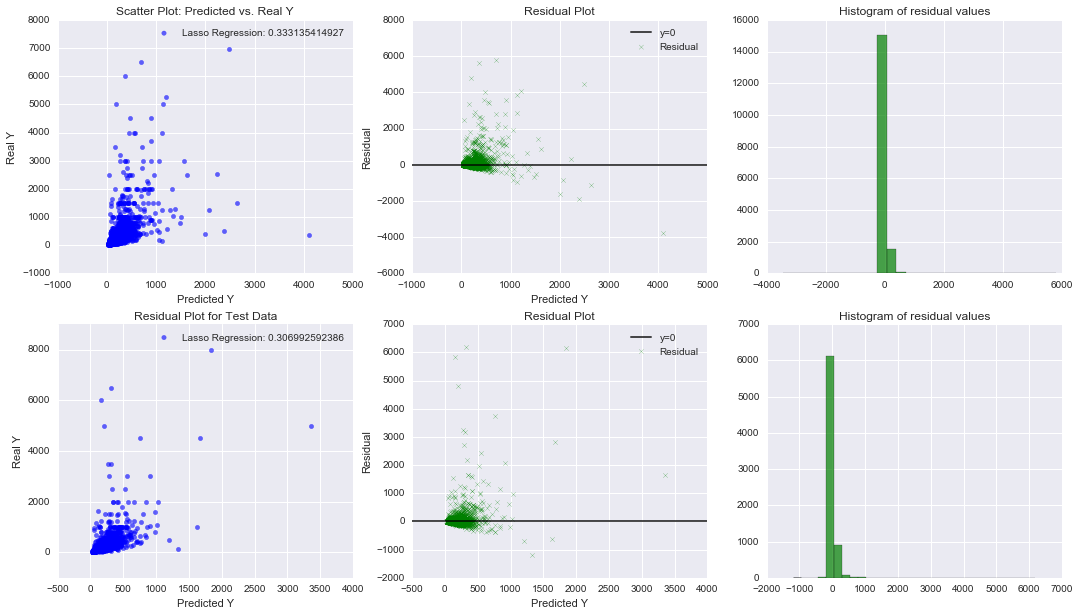

In [38]:
# plot the residuals of a lasso regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

lasso_data_vals = LassoCV_model.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], lasso_data_vals[2]['y_pred'], lasso_data_vals[2]['y_real'], 'Lasso Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], lasso_data_vals[3]['y_pred_test'], lasso_data_vals[3]['y_real_test'], 'Lasso Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()

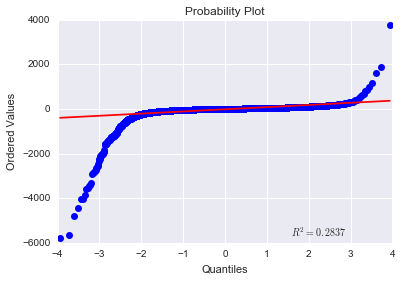

In [39]:
# qq plot for the train residuals
stats.probplot(lasso_data_vals[2]['y_pred'] - lasso_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

### Analysis of Ridge and Lasso Regression

We see that using Ridge Regression as well as Lasso Regression perform similarly on the training and testing data. While the predictions for the testing data have shown a dramatic increase in $R^2$. We see that for all Linear Regression, Ridge and Lasso the train scores are fairly similar. Both Ridge and Lasso perform significantly better on a log-transformed response variable. We also see that the testing score has significantly improved using these models on a log-transformed response variable. 

Based on the residual plots for the log-transformed response, we see that the residuals are more concentrated around 0 with a less noticeable pattern. From the histogram of the residuals, we see that the data appears to be symmetrically clustered around 0. While from the Q-Q plot, the residuals are not perfectly normally distributed, we do see a significant improvement over a model using a non-transformed response variable. From this, we can conclude that a Ridge and Lasso Regression certainly yield predictive power for Airbnb listings.

## Polynomial RidgeCV Model

In [40]:
#Function for calculating BIC
BIC = lambda n, d, RSS: n * np.log(RSS * 1. / n) + d * np.log(n)
#Function for calculating Residual Sum of Squares
RSS = lambda predict, actual: np.sum((predict - actual)**2)

#Function for finding the best polynomial model using Ridge polynomial regression
def best_poly_model(pred, response, max_deg, reg_params):
    #Best regularization parameter for each degree
    lambdas = []
    #Best BIC for each degree
    bics = []
    #Best model parameters for each degree
    params = []
    
    #Iterate through degrees 1 to max_degree
    for degree in range(2, max_deg):
        #Turn one predictor into 1, t, t^2, t^3, ...
        poly_t = PolynomialFeatures(degree=degree)
        pred_expanded = poly_t.fit_transform(pred)
        
        #Perform Ridge regression using expanded set of predictors, 
        #choose best regularization parameter lambda using 5-fold x-validation
        ridge = RidgeCV(alphas=reg_params, fit_intercept=True, cv=5)
        ridge.fit(pred_expanded, response)
        
        #Record the parameters of the model chosen by 5-fold x-validation
        params.append(ridge.coef_)
        #Record the lambda chosen by 5-fold x-validation
        lambdas.append(ridge.alpha_)
        
        #Record the BIC score of the model chosen by 5-fold x-validation
        response_hat = ridge.predict(pred_expanded)        
        error = RSS(response_hat, response)
        bics.append(BIC(pred.shape[0], degree, error))
    
    #Find the degree with the min BIC score
    best_degree = np.argmin(bics) + 1
    #Find the best lambda for the degree with the min BIC score
    best_lambda = lambdas[best_degree - 1]
    #Find the best model parameters for the degree with the min BIC score
    best_params = params[best_degree - 1]
    return best_degree, best_lambda, best_params       

In [41]:
reg_params = 10.**np.linspace(-10, 5, 10)
x_train, x_test, y_train, y_test = train_test_split(x, y_log, test_size=0.75)
best_degree, best_lambda, best_params = best_poly_model(x_train, y_train, 3, reg_params)    

KeyboardInterrupt: 

In [200]:
poly_t = PolynomialFeatures(degree=best_degree)
pred_expanded = poly_t.fit_transform(x_train)
pred_test_expanded = poly_t.fit_transform(x_test)
ridge = RidgeCV(alphas=[best_lambda], fit_intercept=True, cv=5)
ridge.fit(pred_expanded, y_train)
train_score = ridge.score(pred_expanded, y_train)
test_score = ridge.score(pred_test_expanded, y_test)

In [201]:
print train_score
print test_score

0.664421265872
0.667284286068


### Analysis

We see that a Polynomial RidgeCV is a promising model; however, it requires a significant amount of computational time and thus we must compromise by lowering the amount of observations in the training data.

## Random Forest Regressor
<hr>

In [42]:
# random forest regressor
def random_forest_model(x_train, y_train, x_test, y_test):
    best_test_score = 0
    best_train_score = 0
    best_depth = 0
    # tune for tree depth from 1 to 20
    for j in range(1, 21):
        rf = RandomForestRegressor(n_estimators=50, max_depth=j, oob_score=True)
        rf.fit(x_train, y_train)
        score_train = rf.score(x_train, y_train)
        score = rf.score(x_test, y_test)
        if score > best_test_score:
            best_test_score = score
            best_train_score = score_train
            best_depth = j
    return best_train_score, best_test_score, best_depth

### Random Forest Regressor Non-Transformed Response

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)
rf_values = random_forest_model(x_train, y_train, x_test, y_test)

In [44]:
print 'Train Score with Best Test:', rf_values[0]
print 'Best Test Score:', rf_values[1]
print 'Best Depth', rf_values[2]

Train Score with Best Test: 0.82042162985
Best Test Score: 0.396110401701
Best Depth 11


### Random Forest Regressor Log-Transformed Response

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y_log, test_size=0.35)
rf_values = random_forest_model(x_train, y_train, x_test, y_test)

In [46]:
print 'Train Score with Best Test:', rf_values[0]
print 'Best Test Score:', rf_values[1]
print 'Best Depth', rf_values[2]

Train Score with Best Test: 0.860332365292
Best Test Score: 0.699027621618
Best Depth 17


### Random Forest Regressor Analysis

We see that Random Forest Regressor yields a slightly higher train score as compared to Ridge and Lasso, which may be a result of overfitting. This overfitting is reflected on the test score, which is slightly lower than the test scores obtained by Ridge and Lasso roughly by 0.04.

## Median Absolute Error

We now use Median Absolute Error as our loss function to evaluate which of the models is doing better. Intuitively, Median Absolute Error is less sensitive to outliers than Mean Squared Error and translates nicely to a dollar amount relative to price.

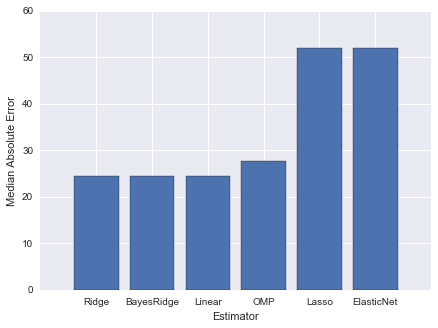

In [47]:
models = [linear_model.LinearRegression(), linear_model.Ridge(),linear_model.Lasso(), linear_model.ElasticNet(), linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
model_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
model_errors = np.array([])

X_train, X_test, y_train, y_test = train_test_split(x, y_log, test_size=0.3, random_state=20)

for model in models:
    model.fit(X_train, y_train)
    model_err = metrics.median_absolute_error(np.exp(y_test), np.exp(model.predict(X_test)))
    model_errors = np.append(model_errors, model_err)

pos = np.arange(model_errors.shape[0])
srt = np.argsort(model_errors)
plt.figure(figsize=(7,5))
plt.bar(pos, model_errors[srt], align='center')
plt.xticks(pos, model_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
plt.show()

## Gradient Boosting Regression
<hr>

In [48]:
# gradient boosting regression
def gradient_boosting_model(x_train, y_train, x_test, y_test):
    best_test_score = 0
    best_train_score = 0
    best_depth = 0
    # tune for tree depth from 1 to 20
    for j in range(1, 21):
        rf = GradientBoostingRegressor(n_estimators=50, max_depth=j, oob_score=True)
        rf.fit(x_train, y_train)
        score_train = rf.score(x_train, y_train)
        score = rf.score(x_test, y_test)
        if score > best_test_score:
            best_test_score = score
            best_train_score = score_train
            best_depth = j
    return best_train_score, best_test_score, best_depth

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35)
rf_values = random_forest_model(x_train, y_train, x_test, y_test)

## Single Listing House Data

We now try regressions on single listings as this is where the majority of our listing data lies; namely listings that only had a bed of 1.

In [50]:
data_single = data[data['beds'] == min(data['beds'])]

# split into x_1 and y_1 (note that we do not include id and host_id as predictors)
x_1 = data_single.iloc[:, 2:-2]
y_1 = data_single.iloc[:, -2]
y_1_log = data_single.iloc[:, -1]

### Linear Regression

In [58]:
model_iterations(10, x_1, y_1_log, linear_regression)

TypeError: 'OrthogonalMatchingPursuit' object is not callable

### Ridge Regression

In [52]:
model_iterations(10, x_1, y_1_log, ridge_regression)

NameError: name 'ridge_regression' is not defined

NameError: name 'plot_residuals_ridge_reg' is not defined

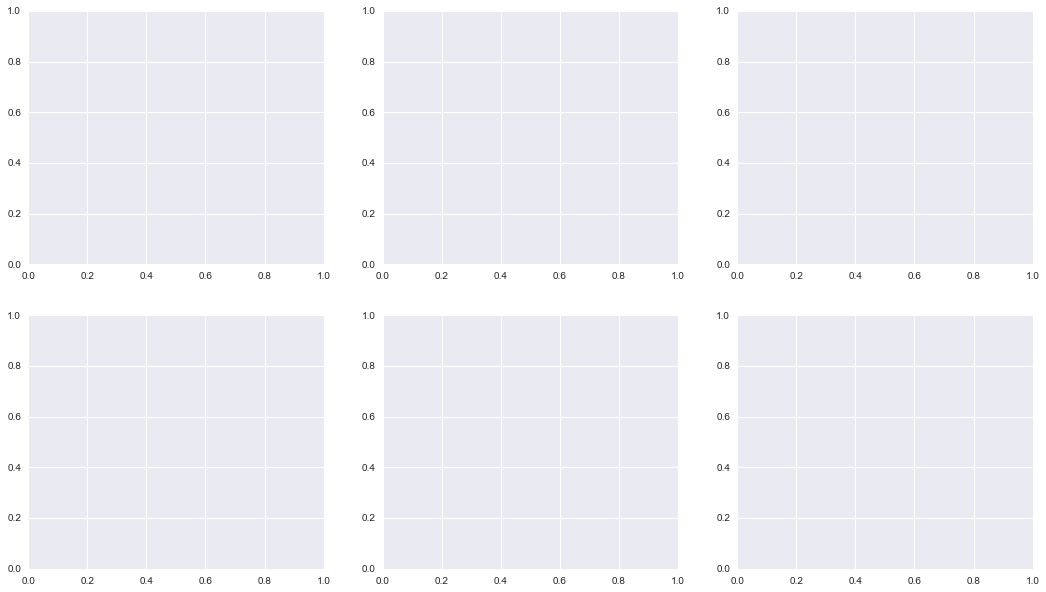

In [53]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = plot_residuals_ridge_reg(x_1, y_1_log)
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()

### Lasso Regression

In [54]:
model_iterations(10, x_1, y_1_log, lasso_regression)

NameError: name 'lasso_regression' is not defined

NameError: name 'plot_residuals_lasso_reg' is not defined

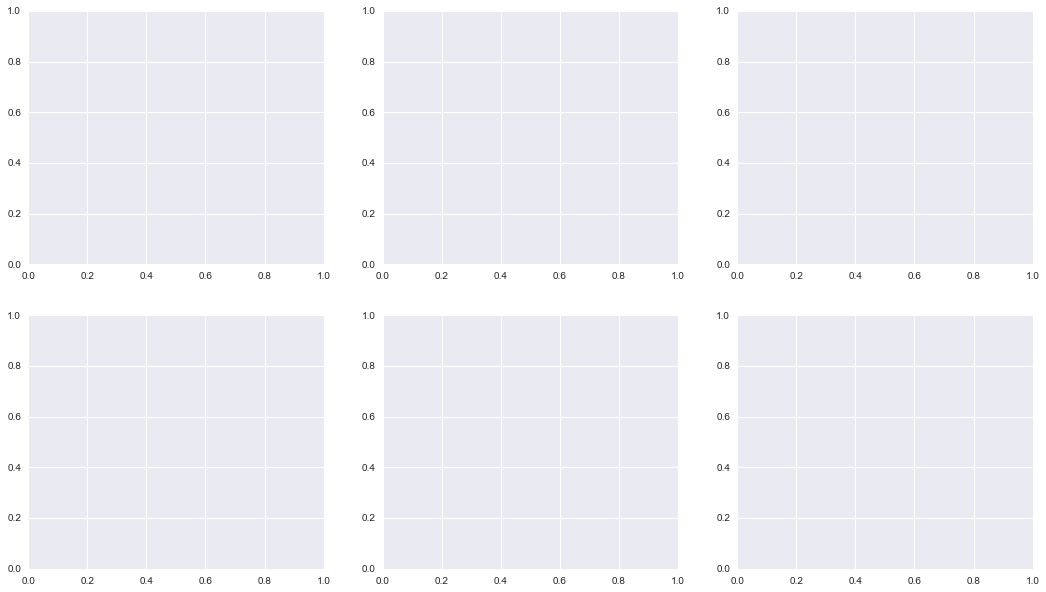

In [55]:
# plot the residuals of a lasso regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

lasso_data_vals = plot_residuals_lasso_reg(x_1, y_1_log)
plot_residual(axes[0][0], axes[0][1], axes[0][2], lasso_data_vals[2]['y_pred'], lasso_data_vals[2]['y_real'], 'Lasso Regression: {}'.format(data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], lasso_data_vals[3]['y_pred_test'], lasso_data_vals[3]['y_real_test'], 'Lasso Regression: {}'.format(data_vals[1]), 'Residual Plot for Test Data')
plt.show()

### Analysis

We see that filtering by single listings does not necessarily improve the performance of our baseline models. We see that the residual plots for just single listings are very similar to the residual plots of our previous regression models. As a sanity check: if we plot a scatter matrix, we see that there there is a similar relationship between the predictors and response for just single listings vs. all listings.

/Users/AlexPeed/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=-0.493059333208, right=-0.493059333208
  'left=%s, right=%s') % (left, right))
/Users/AlexPeed/anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=-0.493059333208, top=-0.493059333208
  'bottom=%s, top=%s') % (bottom, top))


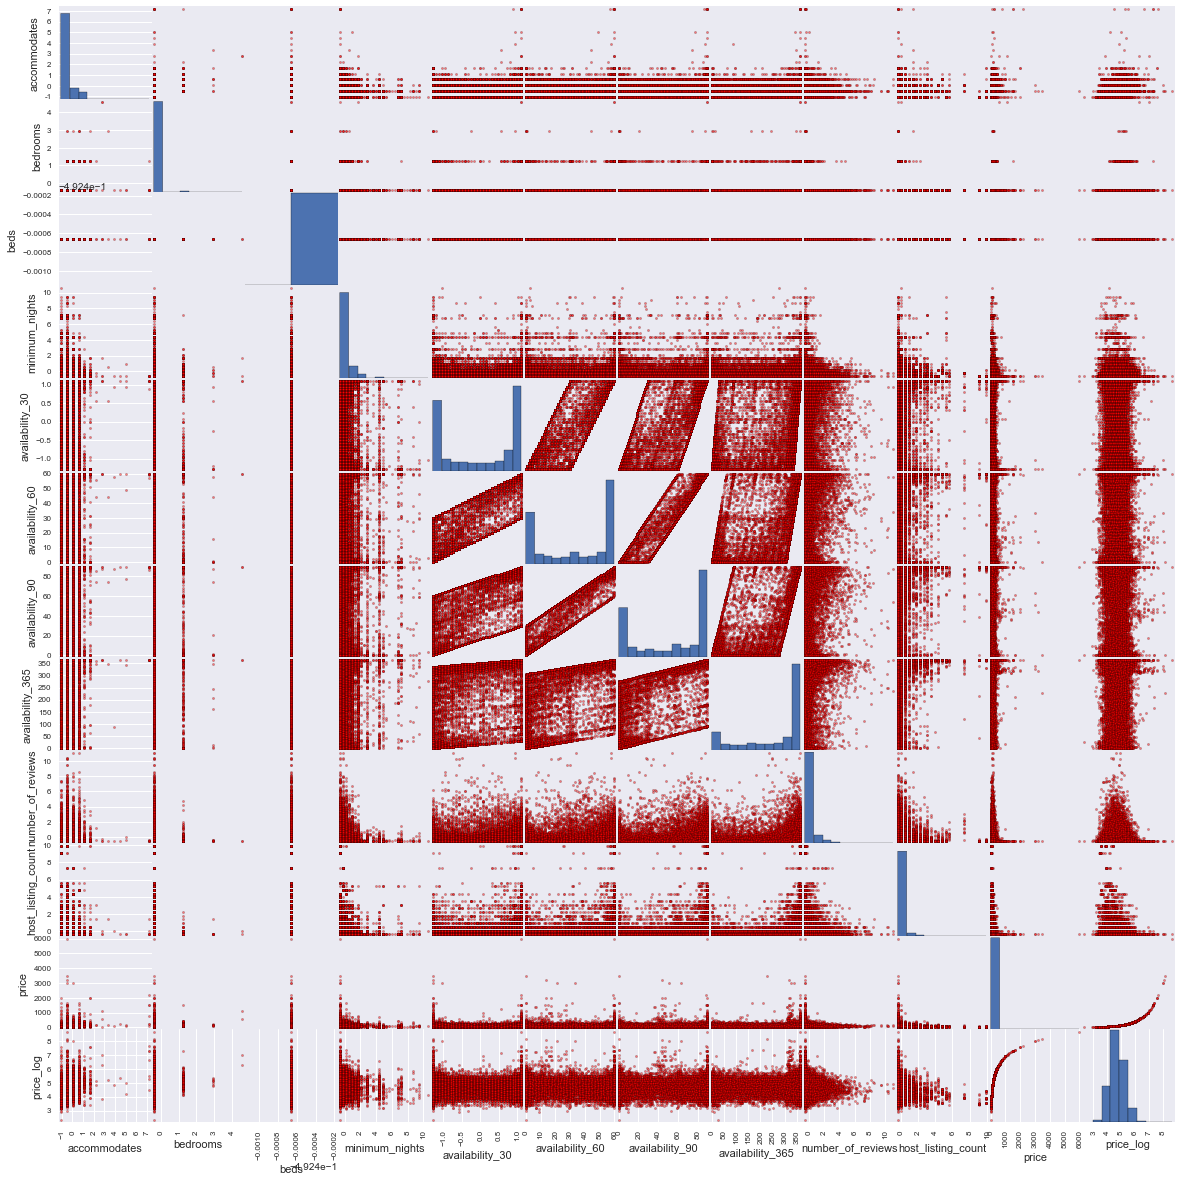

In [56]:
# check for collinearity and visualize relationship between each predictor and price
matrix_cols = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'host_listing_count', 'price', 'price_log']
axs = pd.scatter_matrix(data_single[matrix_cols], figsize=(20, 20), c='red')